In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, MaxPooling2D, AveragePooling2D, BatchNormalization, TimeDistributed, Permute, ReLU, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


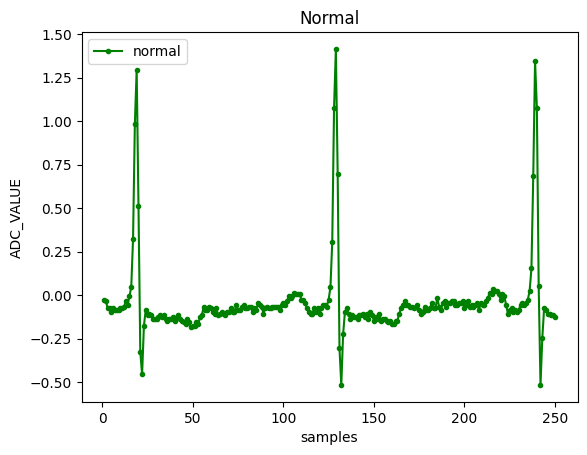

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Load normal ECG data
normal_filename = r"/content/drive/MyDrive/Thesis/Final_normal_data.csv"
normal_df = pd.read_csv(normal_filename, skiprows=range(1, 250), nrows=250)

# Plot abnormal ECG data
index = range(1, len(normal_df['Time']) + 1)
plt.plot(index, normal_df['ECG1'], 'g.', label='normal', linestyle='solid')
plt.title("Normal")
plt.xlabel("samples")
plt.ylabel("ADC_VALUE")
plt.legend()
plt.show()


# New Section

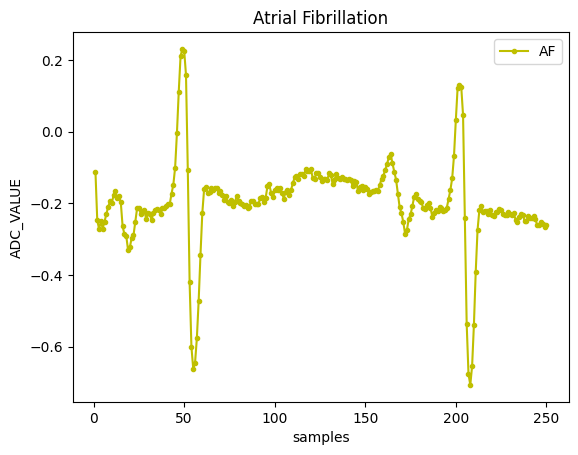

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Load normal ECG data
AF_filename = r"/content/drive/MyDrive/Thesis/Final_AF_data.csv"
AF_df = pd.read_csv(AF_filename, skiprows=range(1, 150000), nrows=250)

# Plot abnormal ECG data
index = range(1, len(AF_df['Time']) + 1)
plt.plot(index, AF_df['ECG1'], 'y.', label='AF', linestyle='solid')
plt.title("Atrial Fibrillation")
plt.xlabel("samples")
plt.ylabel("ADC_VALUE")
plt.legend()
plt.show()

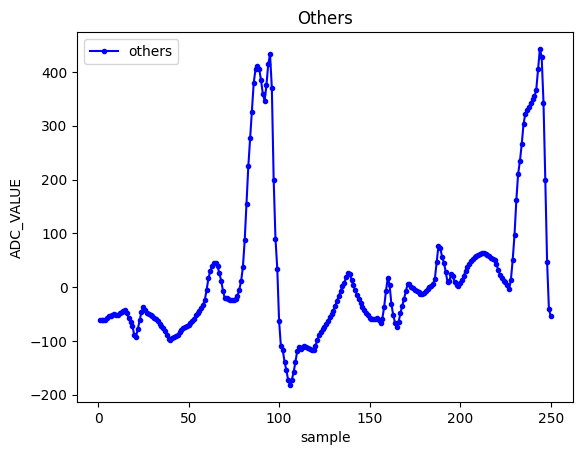

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Load normal ECG data
others_filename = r"/content/drive/MyDrive/Thesis/others.csv"
others_df = pd.read_csv(others_filename, skiprows=range(1, 150000), nrows=250)

# Plot abnormal ECG data
index = range(1, len(others_df['Time']) + 1)
plt.plot(index, others_df['ECG1'], 'b.', label='others', linestyle='solid')
plt.title("Others")
plt.xlabel("sample")
plt.ylabel("ADC_VALUE")
plt.legend()
plt.show()

In [7]:
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
CLASS = [
    "normal",
    "AF"
]

SAMPLES_PER_PERSON = 5000

NUM_CLASSES = len(CLASS)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_CLASSES = np.eye(NUM_CLASSES)

inputs = []
outputs = []

# read each csv file and push an input and output
for ecg_index in range(NUM_CLASSES):
  ecg = CLASS[ecg_index]
  print(f"Processing index {ecg_index} for ECG : '{ecg}'.")

  output = ONE_HOT_ENCODED_CLASSES[ecg_index]

  # Construct the file path for the current ECG class
  file_path = f"/content/drive/MyDrive/Thesis/Final_{ecg}_data.csv"  #D:\Varsity\Thesis\ECG dataset\Physionet

  df = pd.read_csv(file_path)

  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_PERSON)
  print(df.shape[0])
  print(f"\tThere are {num_recordings} recordings of the {ecg} ECG.")

  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_PERSON):
      index = i * SAMPLES_PER_PERSON + j
      # normalize the input data, between 0 to 1:

      tensor += [
          df['ECG1'][index],
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)
print(inputs.shape)
print(outputs.shape)
#print(inputs)
#print(outputs)

print("Data set parsing and preparation complete.")

Processing index 0 for ECG : 'normal'.
130560
	There are 26 recordings of the normal ECG.
Processing index 1 for ECG : 'AF'.
345000
	There are 69 recordings of the AF ECG.
(95, 5000)
(95, 2)
Data set parsing and preparation complete.


In [48]:
num_inputs = len(inputs)
print(num_inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]


# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

X_train, X_test, X_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
Y_train, Y_test, Y_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print(X_train.shape)
print(Y_train.shape)
print(X_validate.shape)
print(X_test.shape)


print("Data set randomization and splitting complete.")

95
(57, 5000)
(57, 2)
(19, 5000)
(19, 5000)
Data set randomization and splitting complete.


In [49]:
# Assuming 'input_data' is your input data with shape (num_samples, data_length)
# Assuming 'window_size' is the size of each window
# Assuming 'stride_size' is the stride value for sliding the window

# Perform sliding window on training input data
windowed_data = []
window_size   = 250
stride_size   = 50

for i in range(len(X_train)):
    for j in range(0, len(X_train[i]) - window_size + 1, stride_size):
        window = X_train[i][j:j+window_size]
        windowed_data.append(window)

# Convert windowed sequences into a numpy array
windowed_data = np.array(windowed_data)

# Reshape the numpy array to the desired format
num_samples = len(X_train)
num_windows = windowed_data.shape[0] // num_samples
X_train = np.reshape(windowed_data, (num_samples, num_windows, window_size))

print(X_train.shape)
print(Y_train.shape)

(57, 96, 250)
(57, 2)


In [50]:
# Assuming 'input_data' is your input data with shape (num_samples, data_length)
# Assuming 'window_size' is the size of each window
# Assuming 'stride_size' is the stride value for sliding the window

# Perform sliding window on training input data
windowed_data = []
window_size   = 250
stride_size   = 50

for i in range(len(X_validate)):
    for j in range(0, len(X_validate[i]) - window_size + 1, stride_size):
        window = X_validate[i][j:j+window_size]
        windowed_data.append(window)

# Convert windowed sequences into a numpy array
windowed_data = np.array(windowed_data)

# Reshape the numpy array to the desired format
num_samples = len(X_validate)
num_windows = windowed_data.shape[0] // num_samples
X_validate = np.reshape(windowed_data, (num_samples, num_windows, window_size))

print(X_validate.shape)
print(Y_validate.shape)

(19, 96, 250)
(19, 2)


In [51]:
# Assuming 'input_data' is your input data with shape (num_samples, data_length)
# Assuming 'window_size' is the size of each window
# Assuming 'stride_size' is the stride value for sliding the window

# Perform sliding window on training input data
windowed_data = []
window_size   = 250
stride_size   = 50

for i in range(len(X_test)):
    for j in range(0, len(X_test[i]) - window_size + 1, stride_size):
        window = X_test[i][j:j+window_size]
        windowed_data.append(window)

# Convert windowed sequences into a numpy array
windowed_data = np.array(windowed_data)

# Reshape the numpy array to the desired format
num_samples = len(X_test)
num_windows = windowed_data.shape[0] // num_samples
X_test = np.reshape(windowed_data, (num_samples, num_windows, window_size))

print(X_test.shape)
print(Y_test.shape)

(19, 96, 250)
(19, 2)


In [9]:
'''window_size = 250
segment_no = 20

print(inputs_train.shape)
print(inputs_test.shape)
print(inputs_validate.shape)

X_train = np.reshape(inputs_train, (-1, segment_no, window_size))
X_test = np.reshape(inputs_test, (-1, segment_no, window_size))
X_validate = np.reshape(inputs_validate, (-1, segment_no, window_size))

#print(inputs_train.shape)
#print(inputs_train[0][0][0])
#print(len(inputs_train[0][0]))
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)



#print(inputs_train)
'''

(57, 5000)
(19, 5000)
(19, 5000)
(57, 20, 250)
(19, 20, 250)
(19, 20, 250)


In [52]:
# Flatten the 2D features to 1D
num_features = X_train.shape[-1]
num_samples = X_train.shape[0]
inputs_train = X_train.reshape(-1, num_features)
outputs_train = Y_train.repeat(96, axis=0)  # Repeat the labels for each array


# Similarly preprocess validation and test data
inputs_validate = X_validate.reshape(-1, num_features)
outputs_validate = Y_validate.repeat(96, axis=0)
inputs_test = X_test.reshape(-1, num_features)
outputs_test = Y_test.repeat(96, axis=0)

print(inputs_train.shape)
print(outputs_train.shape)
print(inputs_validate.shape)
print(outputs_validate.shape)
print(inputs_test.shape)
print(outputs_test.shape)


(5472, 250)
(5472, 2)
(1824, 250)
(1824, 2)
(1824, 250)
(1824, 2)


In [53]:

inputs_train = inputs_train.reshape((5472, 250, 1))
inputs_validate = inputs_validate.reshape((1824, 250, 1))
inputs_test = inputs_test.reshape((1824, 250, 1))



print(inputs_train.shape)
print(outputs_train.shape)
print(inputs_validate.shape)
print(outputs_validate.shape)
print(inputs_test.shape)
print(outputs_test.shape)

(5472, 250, 1)
(5472, 2)
(1824, 250, 1)
(1824, 2)
(1824, 250, 1)
(1824, 2)


In [54]:
print(inputs.shape)
print(inputs.shape)

(95, 5000)
(95, 5000)


In [55]:
print(inputs_train.shape)
print(inputs_test.shape)
print(inputs.shape)


(5472, 250, 1)
(1824, 250, 1)
(95, 5000)


In [56]:
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, MaxPooling1D, GlobalAveragePooling1D, Dense, Softmax
import tensorflow.keras.backend as K

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, MaxPooling1D, GlobalAveragePooling1D, Dense, Softmax

# Define ResNet Block 1
def resnet_block_1(x, filters):
    shortcut = x

    #x = BatchNormalization()(x)
    x = Conv1D(filters, kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters, kernel_size=5, strides=1, padding='same')(x)


    shortcut = Conv1D(filters, kernel_size=1, strides=1, padding='same')(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Define ResNet Block 2
def resnet_block_2(x, filters):
    shortcut = Conv1D(filters, kernel_size=1, strides=1, padding='same')(x)



    x = Conv1D(filters, kernel_size=5, strides=1, padding='same')(x)
    x = MaxPooling1D(pool_size=2, strides=2)(x)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters, kernel_size=5, strides=1, padding='same')(x)



    x = Conv1D(filters, kernel_size=5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Add max-pooling to the shortcut connection
    shortcut = MaxPooling1D(pool_size=2, strides=2)(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Custom function for computing attention weights
def attention(x):
    # Calculate attention weights using tanh and softmax
    attention_weights = Softmax(axis=1)(K.tanh(x))
    return attention_weights


# Input layer
input_layer = Input(shape=(250, 1))

# Initial layers
x = BatchNormalization()(input_layer)
x = Conv1D(16, kernel_size=5, strides=1, padding='same')(x)
x = ReLU()(x)

# 2 times ResNet Block 1
for _ in range(2):
    x = resnet_block_1(x, 16)

# 1 time ResNet Block 2
x = resnet_block_2(x, 16)

# 3 times ResNet Block 1
for _ in range(3):
    x = resnet_block_1(x, 32)

# 1 time ResNet Block 2
x = resnet_block_2(x, 64)

# 4 times ResNet Block 1
for _ in range(4):
    x = resnet_block_1(x, 128)

# 1 time ResNet Block 2
x = resnet_block_2(x, 128)

# Global Average Pooling
x = GlobalAveragePooling1D()(x)

from tensorflow.keras.layers import Input,Reshape, Conv1D, BatchNormalization, ReLU, Add, MaxPooling1D, GlobalAveragePooling1D, Dense, Softmax, Lambda, Multiply,Dropout
# Feature Attention Mechanism (inserted here)
attention_weights = Lambda(attention)(x)  # Apply attention mechanism
x = Multiply()([x, attention_weights])  # Multiply feature map by attention weights


# Add dropout layers to your model
x = Dense(64, activation='relu')(x)
#x = MaxPooling1D(pool_size=2, strides=2)(x)
#x = Dropout(0.5)(x)  # You can adjust the dropout rate


# Output layer
output_layer = Dense(2, activation='sigmoid')(x)  # num_classes is the number of output classes

# Create the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Print the model summary
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 250, 1)]             0         []                            
                                                                                                  
 batch_normalization_50 (Ba  (None, 250, 1)               4         ['input_3[0][0]']             
 tchNormalization)                                                                                
                                                                                                  
 conv1d_80 (Conv1D)          (None, 250, 16)              96        ['batch_normalization_50[0][0]
                                                                    ']                            
                                                                                            

In [58]:
from tensorflow import keras


# Step 3: Model Training Configuration
num_epochs = 50  # Adjust as needed
batch_size = 10  # Adjust as needed
learning_rate = 0.00001  # Adjust as needed
checkpoint_path = 'model_checkpoint.h5'  # Path to save model checkpoints



optim = tf.optimizers.Adam(learning_rate = learning_rate)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, patience=6, min_lr=1e-6, verbose=1)

checkpoint_filepath = os.path.join(r"/content/drive/MyDrive/Thesis", 'resnet_model_V3.h5')

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(inputs_train, outputs_train, validation_data =(inputs_validate, outputs_validate),
          epochs = num_epochs, batch_size = batch_size, shuffle=True, callbacks=[reduce_lr, model_checkpoint])




Epoch 1/50
548/548 [==============================] - ETA: 0s - loss: 0.0502 - accuracy: 0.9845
Epoch 1: val_accuracy improved from -inf to 0.99178, saving model to /content/drive/MyDrive/Thesis/resnet_model_V3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


548/548 [==============================] - 52s 46ms/step - loss: 0.0502 - accuracy: 0.9845 - val_loss: 0.0314 - val_accuracy: 0.9918 - lr: 0.0010
Epoch 2/50
548/548 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9883
Epoch 2: val_accuracy did not improve from 0.99178
548/548 [==============================] - 22s 40ms/step - loss: 0.0408 - accuracy: 0.9883 - val_loss: 0.0833 - val_accuracy: 0.9863 - lr: 0.0010
Epoch 3/50
548/548 [==============================] - ETA: 0s - loss: 0.0365 - accuracy: 0.9876
Epoch 3: val_accuracy improved from 0.99178 to 0.99616, saving model to /content/drive/MyDrive/Thesis/resnet_model_V3.h5
548/548 [==============================] - 24s 44ms/step - loss: 0.0365 - accuracy: 0.9876 - val_loss: 0.0257 - val_accuracy: 0.9962 - lr: 0.0010
Epoch 4/50
548/548 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9940
Epoch 4: val_accuracy did not improve from 0.99616
548/548 [==============================] - 23s 43ms

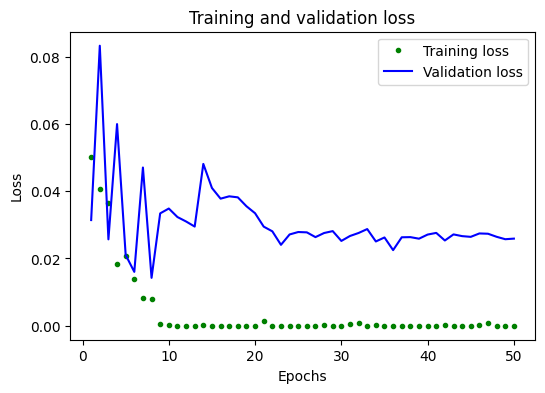

[6.0, 4.0]


In [59]:

# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (6,4)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

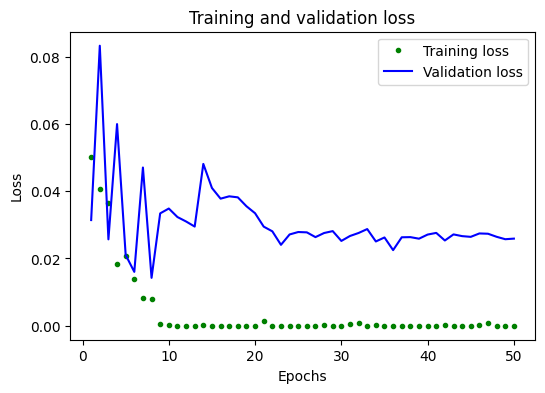

[6.0, 4.0]


In [60]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (6,4)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

In [61]:
# Step 5: Evaluation
test_loss, test_accuracy = model.evaluate(inputs_test, outputs_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

57/57 [==============================] - 0s 8ms/step - loss: 0.0183 - accuracy: 0.9940
Test Loss: 0.018345629796385765
Test Accuracy: 0.9939693212509155


In [62]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)
y_true = outputs_test
y_pred = predictions

57/57 [==============================] - 1s 7ms/step
predictions =
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
actual =
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


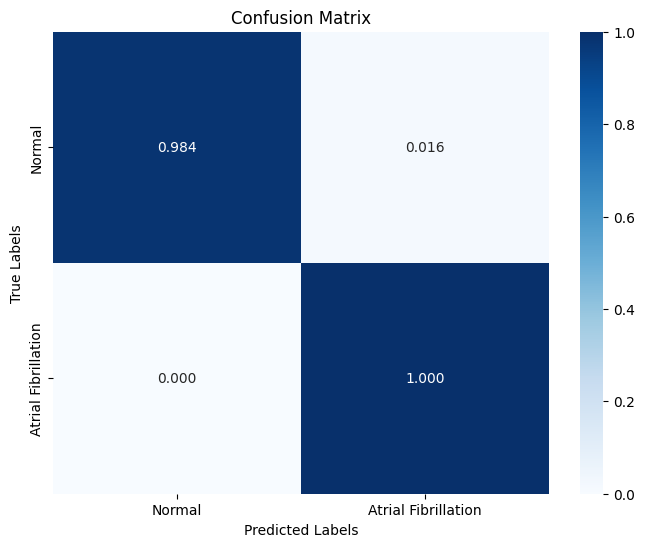

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(outputs_test.argmax(axis=1), predictions.argmax(axis=1))
# Normalize the confusion matrix to show percentages
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

class_names = ["Normal", "Atrial Fibrillation"]

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
#sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues")
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".3f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [64]:
from sklearn.metrics import classification_report

classification_rep = classification_report(outputs_test.argmax(axis=1), predictions.argmax(axis=1))
print(classification_rep)


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       672
           1       0.99      1.00      1.00      1152

    accuracy                           0.99      1824
   macro avg       1.00      0.99      0.99      1824
weighted avg       0.99      0.99      0.99      1824



In [65]:
from sklearn.metrics import recall_score

recall = recall_score(outputs_test.argmax(axis=1), predictions.argmax(axis=1), average='weighted')
print(f"Recall: {recall}")


Recall: 0.9939692982456141


In [66]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)
#y_true = outputs_test
#y_pred = predictions


57/57 [==============================] - 0s 7ms/step
predictions =
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
actual =
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
c